In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import time


In [3]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy(pred, target):
    m = target.shape[0]
    log_likelihood = -np.log(pred[range(m), target])
    return np.sum(log_likelihood) / m

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax_derivative(output, target):
    m = target.shape[0]
    grad = output.copy()
    grad[range(m), target] -= 1
    grad /= m
    return grad

In [3]:
import numpy as np

def pad2d(x, pad):
    if pad == 0:
        return x
    return np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Xavier initialization
        scale = np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * scale
        self.biases = np.zeros((out_channels, 1))
        self.input = None

    def forward(self, x):
        self.input = x
        batch_size, in_channels, in_height, in_width = x.shape
        
        # Padding
        if self.padding > 0:
            x_padded = np.pad(x, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)))
        else:
            x_padded = x
        
        # Output dimensions
        out_height = (in_height + 2*self.padding - self.kernel_size) // self.stride + 1
        out_width = (in_width + 2*self.padding - self.kernel_size) // self.stride + 1
        
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))
        
        # Vectorized convolution
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        region = x_padded[b, :, h_start:h_start+self.kernel_size, w_start:w_start+self.kernel_size]
                        output[b, oc, i, j] = np.sum(region * self.weights[oc]) + self.biases[oc]
        return output

    def backward(self, d_out, learning_rate=0.01):
        batch_size, _, _, _ = d_out.shape
        x_padded = np.pad(self.input, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)))
        dx_padded = np.zeros_like(x_padded)
        d_weights = np.zeros_like(self.weights)
        d_biases = np.zeros_like(self.biases)

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(d_out.shape[2]):
                    for j in range(d_out.shape[3]):
                        h_start = i * self.stride
                        w_start = j * self.stride
                        region = x_padded[b, :, h_start:h_start+self.kernel_size, w_start:w_start+self.kernel_size]
                        d_weights[oc] += d_out[b, oc, i, j] * region
                        d_biases[oc] += d_out[b, oc, i, j]
                        dx_padded[b, :, h_start:h_start+self.kernel_size, w_start:w_start+self.kernel_size] += d_out[b, oc, i, j] * self.weights[oc]

        # Remove padding
        if self.padding > 0:
            dx = dx_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dx = dx_padded

        # Update weights
        self.weights -= learning_rate * d_weights
        self.biases -= learning_rate * d_biases
        
        return dx

In [4]:
class MaxPool2D:
    def __init__(self, size=2, stride=2):
        self.size = size
        self.stride = stride
        self.input = None
        self.max_indices = None

    def forward(self, x):
        self.input = x
        batch_size, channels, height, width = x.shape
        out_height = height // self.size
        out_width = width // self.size
        output = np.zeros((batch_size, channels, out_height, out_width))
        self.max_indices = np.zeros((batch_size, channels, out_height, out_width, 2), dtype=int)
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        h_start = i * self.size
                        w_start = j * self.size
                        region = x[b, c, h_start:h_start+self.size, w_start:w_start+self.size]
                        max_val = np.max(region)
                        output[b, c, i, j] = max_val
                        max_idx = np.unravel_index(np.argmax(region), region.shape)
                        self.max_indices[b, c, i, j] = [h_start + max_idx[0], w_start + max_idx[1]]
        return output

    def backward(self, d_out):
        batch_size, channels, height, width = self.input.shape
        d_input = np.zeros_like(self.input)
        
        for b in range(batch_size):
            for c in range(channels):
                for i in range(d_out.shape[2]):
                    for j in range(d_out.shape[3]):
                        h, w = self.max_indices[b, c, i, j]
                        d_input[b, c, h, w] = d_out[b, c, i, j]
        return d_input


In [5]:
class FullyConnected:
    def __init__(self, input_size, output_size):
        # Xavier initialization
        scale = np.sqrt(2.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * scale
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None

    def forward(self, x):
        self.input = x
        self.output = np.dot(x, self.weights) + self.bias
        return relu(self.output)

    def backward(self, d_out, learning_rate=0.01):
        d_out = d_out * relu_derivative(self.output)
        d_input = np.dot(d_out, self.weights.T)
        d_weights = np.dot(self.input.T, d_out)
        d_bias = np.sum(d_out, axis=0, keepdims=True)

        self.weights -= learning_rate * d_weights
        self.bias -= learning_rate * d_bias
        return d_input

In [6]:
class CNN:
    def __init__(self):
        self.conv1 = Conv2D(1, 16, kernel_size=3, padding=1)  # Matches PyTorch reference
        self.pool1 = MaxPool2D(size=2)
        self.conv2 = Conv2D(16, 32, kernel_size=3, padding=1)  # Matches PyTorch reference
        self.pool2 = MaxPool2D(size=2)
        self.fc1 = FullyConnected(32 * 7 * 7, 128)
        self.fc2 = FullyConnected(128, 10)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = relu(x)
        x = self.pool1.forward(x)
        
        x = self.conv2.forward(x)
        x = relu(x)
        x = self.pool2.forward(x)
        
        x = x.reshape(x.shape[0], -1)  # Flatten
        x = self.fc1.forward(x)
        x = self.fc2.forward(x)
        return softmax(x)


Sample Predictions:


C:\Users\Hello\AppData\Local\Temp\ipykernel_25980\2028256395.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, oc, i, j] = np.sum(region * self.weights[oc]) + self.biases[oc]


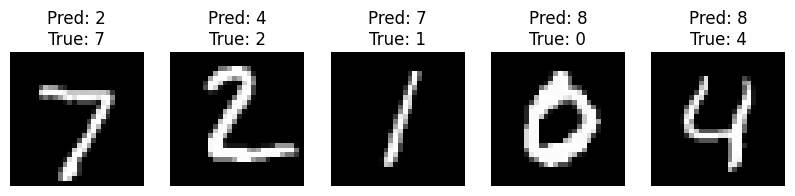

In [11]:
def show_predictions(model, data_loader, num_samples=5):
    images, labels = next(iter(data_loader))
    images, labels = images.numpy(), labels.numpy()
    outputs = model.forward(images)
    predictions = np.argmax(outputs, axis=1)

    plt.figure(figsize=(10, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        plt.axis('off')
    plt.show()

print("Sample Predictions:")
show_predictions(CNN(), test_loader)


In [8]:
model = CNN()

def train(model, train_loader, epochs=5, learning_rate=0.01):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        start_time = time.time()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.numpy()
            labels = labels.numpy()

            # Forward pass
            output = model.forward(images)
            loss = cross_entropy(output, labels)
            epoch_loss += loss * len(labels)  # Weight by batch size

            # Backward pass
            grad = softmax_derivative(output, labels)
            grad = model.fc2.backward(grad, learning_rate)
            grad = model.fc1.backward(grad, learning_rate)
            
            # Reshape and backprop through conv/pool layers
            grad = grad.reshape(-1, 32, 7, 7)
            grad = model.pool2.backward(grad)
            grad = model.conv2.backward(grad, learning_rate)
            grad = model.pool1.backward(grad)
            model.conv1.backward(grad, learning_rate)

            # Metrics
            predictions = np.argmax(output, axis=1)
            correct += np.sum(predictions == labels)
            total += len(labels)
            
            # Progress update
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | "
                      f"Loss: {epoch_loss/total:.4f} | Acc: {correct/total*100:.2f}%", end='\r')

        # Epoch statistics
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = correct / len(train_loader.dataset)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc*100:.2f}% | "
              f"Time: {time.time()-start_time:.2f}s")

    return history


In [9]:
def evaluate(model, data_loader):
    y_true = []
    y_pred = []
    total_loss = 0
    
    for images, labels in data_loader:
        images = images.numpy()
        labels = labels.numpy()
        
        output = model.forward(images)
        predictions = np.argmax(output, axis=1)
        
        y_true.extend(labels)
        y_pred.extend(predictions)
        total_loss += cross_entropy(output, labels) * len(labels)
    
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    
    print("\nEvaluation Results:")
    print(f"Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    return accuracy

def plot_training(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
if __name__ == "__main__":
    # Load data
    transform = transforms.ToTensor()
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize and train model
    model = CNN()
    history = train(model, train_loader, epochs=5)
    
    # Evaluate and plot
    test_acc = evaluate(model, test_loader)
    plot_training(history)